<a href="https://colab.research.google.com/github/chrisdewey/Movie-Recommender-SVD/blob/main/Movie_Recommender_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
%pip install scikit-surprise
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, accuracy, Dataset, Reader, dump
from surprise.model_selection import cross_validate, train_test_split
import ipywidgets as widgets
from IPython.display import clear_output, display
import logging
from pathlib import Path

logger = logging.getLogger('log1')
logging.basicConfig(
    filename='app.log',
    format='%(name)s - %(levelname)s - %(message)s'
)

%matplotlib inline

     |████████████████████████████████| 11.8 MB 4.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630163 sha256=9dfe6ab760a3fa9c9801c5d28366116bf3a0bab708379889eac298e6b41b23e5
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


#Upload Datasets

The datasets are hosted on GitHub and are imported directly from there. Alternatively, you can upload the datasets manually using the commented-out code below.

In [2]:
# Permalinks to the datasets stored on GitHub
ratings_url = 'https://raw.githubusercontent.com/chrisdewey/Movie-Recommender-SVD/main/datasets/ratings.csv'
movies_url = 'https://raw.githubusercontent.com/chrisdewey/Movie-Recommender-SVD/main/datasets/movies.csv'

# Alternatively, you can upload the datasets manually using the code below:

# from google.colab import files
# print('Upload ratings.csv')
# ratings_csv = files.upload()
# print('Upload movies.csv')
# movies_csv = files.upload()

# The dataset can be obtained from Grouplens here:
# https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

# Please note:
# The upload function of the Google Colab Notebook does not work if using a
# Chromium browser in Incognito mode, or if third-party cookies are blocked. 

#Prepare the data

In [3]:
# Read the datasets
df_movies = pd.read_csv(movies_url)
df_ratings = pd.read_csv(ratings_url)

# If uploading datasets manually, use the code below.

# df_mt = pd.read_csv('/content/movies.csv',
#                          usecols=['movieId', 'title'],
#                          dtype={'movieId': 'int32', 'title': 'str'})
# df_rt = pd.read_csv('/content/ratings.csv',
#                           usecols=['userId', 'movieId', 'rating', 'timestamp'],
#                           dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})  # maybe remove 'timestamp'

In [4]:
df_merged = df_movies.merge(df_ratings, on='movieId')

avg_movie_rating = df_merged.groupby('title')['rating']\
    .mean().sort_values(ascending=False).reset_index().rename(columns={'rating': 'Avg Rating'})

rating_count = df_merged.groupby('title')['rating']\
    .count().sort_values(ascending=True).reset_index().rename(columns={'rating': 'Rating Count'})

df_incl_rc = df_merged.merge(rating_count, left_on='title', right_on='title', how='left')

rating_count_avg = rating_count.merge(avg_movie_rating, on='title')

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # This was normally COMMENTED OUT?? WHY?? GUESS I DON"T NEED IT? DELETE IF BREAKS> REMOVE COMMENT>


#Exploratory Data Analysis

In [5]:
# import matplotlib.pyplot as plt  # already imported.... SORT IMPORTS... AND COMMENTS lol
sns.set(font_scale=1)
plt.style.use('dark_background')


Text(0, 0.5, 'Rating Count (Scaled)')

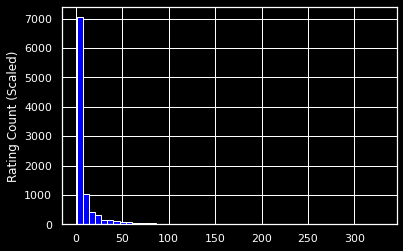

In [6]:
plt.hist(rating_count['Rating Count'], bins=50, color='blue')
plt.ylabel('Rating Count (Scaled)')

In the above histogram, we see that there are many movie which have very few ratings.

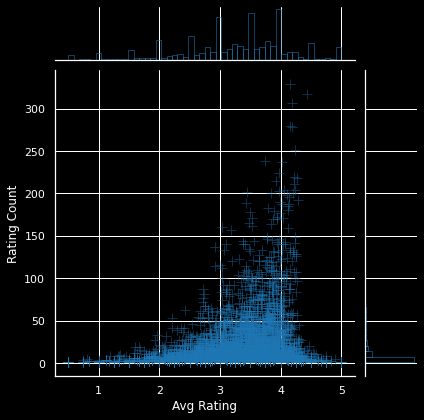

In [7]:
# plt.rcParams["axes.grid"] = False
plot = sns.jointplot(x='Avg Rating', marker='+', y='Rating Count', s=100, marginal_kws=dict(bins=50, fill=False), data=rating_count_avg, alpha=0.5, color='tab:blue')

The above scatter jointplot shows the relationship between the Average Rating (the x axis) and the Rating Count (the y axis). As we can see, while there are many films with 5 star ratings, virtually none of these have a high rating count. The same holds true for films with extremely low ratings.

To prevent noise in the data which will skew our SVD model, we must establish a usability threshold, whereupon a film, having a high enough rating count, may stay in the dataset for training. Otherwise, the film is removed.

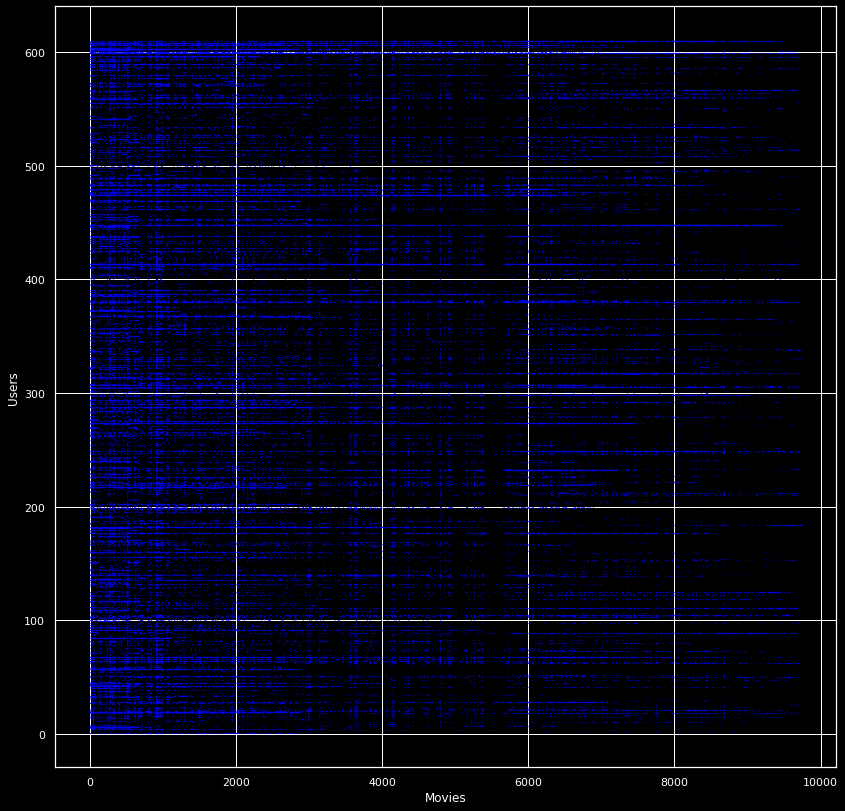

In [8]:
# First we rank the columns column to portray an accurate spread of data rather than the unique ID numbers.
df_merged['movieId'] = df_merged['movieId'].rank(method='dense')
df_merged['userId'] = df_merged['userId'].rank(method='dense')

# Create Scatter Plot with movieId as x axis and userId as y axis.
df_merged.plot(x='movieId', y='userId', s=.05, kind='scatter', figsize=(14,14), c='blue')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()

The above scatter plot visualizes the where there are ratings by users on movies. Where there is a blue dot, there is a rating by that user on that movie.

#Establish Threshold

The popularity_threshold variable below is used to remove films which have a rating which is too low. Any film with a rating count below the threshold will be removed.

In [9]:
popularity_threshold = 5
popular_movies = df_incl_rc[df_incl_rc['Rating Count'] >= popularity_threshold]

In [10]:
movie_ids = popular_movies.movieId.unique().tolist()
titles = popular_movies.title.unique().tolist()

# Two dicts for quick look-up later on.
title_dict = df_movies.set_index('title').to_dict()['movieId']
reverse_title_dict = df_movies.set_index('movieId').to_dict()['title']

In [11]:
# Format the Dataframe for use in the Scikit Suprise library
df_data = popular_movies.drop(['title', 'timestamp', 'Rating Count'], axis=1)
df_data.rename(columns={'movieId': 'Item', 'userId': 'User', 'rating': 'Rating'}, inplace=True)
df_data.reindex(columns=['User', 'Item', 'Rating'])

,User,Item,Rating
0,1,1,4.000
1,5,1,4.000
2,7,1,4.500
3,15,1,2.500
4,17,1,4.500
...,...,...,...
100797,62,187595,4.000
100798,380,187595,4.000
100799,414,187595,3.500
100800,514,187595,3.000


#User Input

In [12]:
#user input
movie_select = widgets.Combobox(
    placeholder='Choose a Movie',
    options=titles,
    description='Movie_select:',
    ensure_option=True,
    disabled=False
)
rating_select = widgets.FloatSlider(
    value=2.5,
    min=0.5,
    max=5.0,
    step=0.1,
    description='Rating_select:',
    disabled=False,
    coninuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
add_button = widgets.Button(
    description='Add movie rating'
)

To add films and ratings:


1.   Run the cell below
2.   Start typing which film you would like to rate, and choose it from the dropdown options
3.   Select the rating you wish to give the film via the Rating Select slider
4.   Press the 'Add movie rating' button to add it to the list
5.   Repeat steps 1 to 4 as many times as desired.



In [26]:
user_preference = dict()

input_widgets = widgets.HBox([movie_select, rating_select])
dash = widgets.VBox([input_widgets, add_button])

def add_vals(b):
  global user_preference
  
  try:
    id = title_dict[movie_select.value]
    print('Rating Added')
  except KeyError:
    logger.warning('Add user film rating FAILED.')
    print('Invalid movie. Please use the exact movie name as provided in the drop-down autocomplete portion of the movie select field.')
  user_preference[id] = rating_select.value

add_button.on_click(add_vals)
display(dash)

Alternatively, if no films are rated by the user to add, sample ratings provieded by the author will be used instead.

In [ ]:
print('Users film ratings:')
print(user_preference)

# If no user ratings were made, use sample ratings:
if not user_preference:
  user_preference = {1: 2.0, 2: 4.4, 5618: 4.1, 8376: 3.5, 8533: 0.5, 51255: 4.6}

In [21]:
# Append the users new data to the rest of the data.
user_df = pd.DataFrame(
    {"User": 700, "Item": user_preference.keys(), "Rating": user_preference.values()}
)
df_data = df_data.append(user_df)
# df_data

#Train Model

In [22]:
min_rating = df_ratings.rating.min()
max_rating = df_ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df_data[['User', 'Item', 'Rating']], reader)
training_parameters = {'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.08}

print("Creating trainset:")
trainset = data.build_full_trainset()
print("done.")

start = datetime.now()
print("Training Started:")
# from surprise import SVDpp
# from surprise.model_selection import train_test_split
algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])
# algo = SVDpp()

# trainset, testset = train_test_split(data, test_size=.25)

algo.fit(trainset)

end = datetime.now()
print("done.\t\t time: ", (end-start).seconds, "seconds")

Creating trainset:
done.
Training Started:
done.		 time:  33 seconds


To save the model for quick re-use later, we can use the Surprise dump() function to pickel the model:

```
model_file = "/content/trained_model.pickle"
import os
file_name = os.path.expanduser(model_file)
dump.dump(file_name, algo=algo)
```

And we can load the same model using:

```
def load_model(model_file):
    print (">> Loading dump")
    file_name = os.path.expanduser(model_file)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model
```

#Cross Validation and Accuracy Testing

You can also run the cross validation yourself by uncommenting the line of code below and running the cell:

In [ ]:
# Un-comment the line of code below and run it to use cross validation to
# measure the accuracy of the model.

# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

The output of the cross validation test with the current model and dataset follows:

| title | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Fold 6 | Fold 7 | Fold 8 | Fold 9 | Fold 10 | Mean | Std |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| RMSE (testset) | 0.8243 | 0.8391 | 0.8226 | 0.8145 | 0.8285 | 0.8300 | 0.8250 | 0.8349 | 0.8275 | 0.8317 | 0.8278 | 0.0065 |
| MAE (testset) | 0.6307 | 0.6375 | 0.6279 | 0.6251 | 0.6319 | 0.6356 | 0.6334 | 0.6368 | 0.6333 | 0.6340 | 0.6326 | 0.0037 |
| Fit time | 24.39 | 24.19 | 25.92 | 23.93 | 24.37 | 24.41 | 24.76 | 24.47 | 35.20 | 24.56 | 25.62 | 3.23 |
| Test time | 0.07 | 0.07 | 0.06 | 0.06 | 0.08 | 0.06 | 0.06 | 0.07 | 0.14 | 0.23 | 0.09 | 0.05 |

#Predict

The model makes predictions of what the user would rate all of the films, and returns the highest predicted rated films as the movie recommendations.

In [24]:
# model_file = "/content/trained_model.pickle"

user_preds = dict()

def recommend(user, n):
  """
  user == the user to return predictions for.
     n == the number of recommendations to return.
  """
  uid = user
  
  rated_films = df_data.loc[df_data["User"] == user, "Item"]
  unknown = np.setdiff1d(movie_ids, rated_films)

  for film in unknown:
    iid = film
    prediction = algo.predict(uid, iid)
    user_preds[film] = prediction.est

    if prediction.details['was_impossible']:
      logger.error('A user or film was not in the trainset.')

  sorted_user_preds = sorted(user_preds.items(), key=lambda x:-x[1])[:n]

  return sorted_user_preds

# The user has an ID of 700
x = recommend(700, 5)

print('Recommendations:')
for i in range(len(x)):
  print(i+1, end="")
  print('. ', end="")
  print(reverse_title_dict[x[i][0]], end="")
  print(', ', end="")
  print("{:.2f}".format(x[i][1]))


Recommendations:
1. Love and Death (1975), 4.77
2. Babette's Feast (Babettes gæstebud) (1987), 4.58
3. Outlaw Josey Wales, The (1976), 4.54
4. Night at the Opera, A (1935), 4.51
5. Eastern Promises (2007), 4.50


#Read Error Logs

If any errors were recorded, they will be displayed here:

In [25]:
print(Path('app.log').read_text())